In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-0vc318ar
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-0vc318ar
  Resolved https://github.com/tensorflow/examples.git to commit b5a8265e0b655001eaa859e7bd8ac9b4e03f3ce8
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1763062947.1037077196981023548712530743058318120274395872488-py3-none-any.whl size=300320 sha256=274449b0602c502fcd920f35fda34a4c9829640b9e545dc7e3c0b72445e3db3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-th7ma33i/wheels/ab/17/30/d16d07e2c95286770a9ddcd6f41629ea92b998858c5ee235aa
Successfully built tensorflow-examples


In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import IPython.display as display


# Часть 1: Загрузка и подготовка датасета Oxford-IIIT Pets

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.UUWMJ8_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.UUWMJ8_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


## Функция для нормализации изображений и масок сегментации

In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    # Маски содержат значения {1, 2, 3}. Приводим к {0, 1, 2}
    input_mask -= 1
    return input_image, input_mask


## Функция для изменения размера изображений и масок

In [ ]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask


In [ ]:
@tf.function
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask


## Получение тренировочного и тестового наборов данных

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000


In [ ]:
train_images = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)


## Настройка набора данных для производительности

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)


## Визуализация примера данных

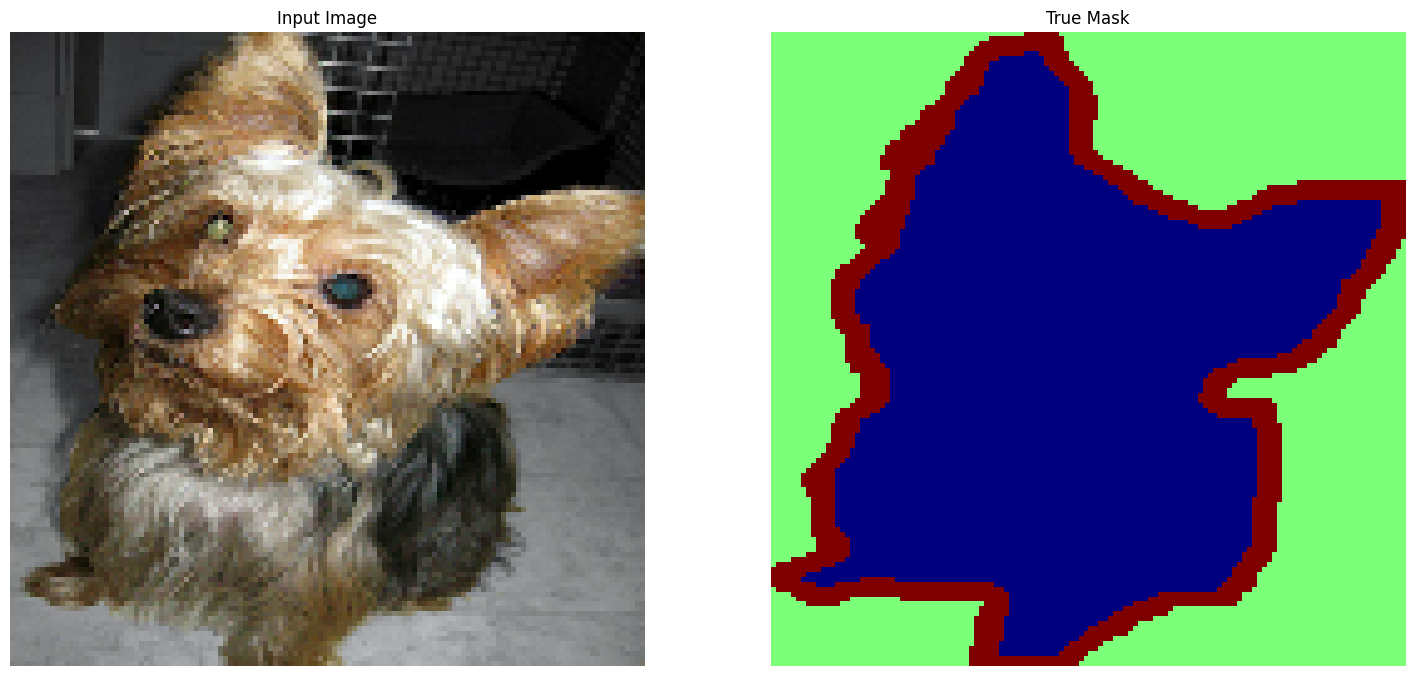

In [ ]:
def display_sample(display_list):
    plt.figure(figsize=(18, 18))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0: # Изображение
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        else: # Маска
            # Используем цветовую карту для визуализации классов
            plt.imshow(display_list[i][:, :, 0], cmap='jet', vmin=0, vmax=2)
        plt.axis('off')
    plt.show()

for images, masks in train_batches.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display_sample([sample_image, sample_mask])


# Часть 2: Определение модели U-Net

## Используем предобученную модель для энкодера (MobileNetV2)

In [ ]:

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Используемые слои для skip-connections

In [ ]:

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]


In [ ]:
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

## Создание энкодера с помощью Functional API

In [ ]:

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False # Заморозка весов энкодера для ускорения обучения


## Декодер (модуль апсемплинга)

In [ ]:

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


## Функция для создания полной модели U-Net

In [ ]:

def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Энкодер (downsampling)
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Декодер (upsampling) с skip-connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # Финальный слой
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  # 64x64 -> 128x128

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)


## Создание модели. 3 выходных канала для 3 классов: фон, тело животного, граница животного

In [ ]:
OUTPUT_CLASSES = 3
model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 64, 64,   │  1,841,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576), (None, 4,   │            │                   │
│                     │ 4, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8, 8, 512) │  1,476,608 │ functional[0][4]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ sequential[0][0], │
│ (Concatenate)       │ 1088)             │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 16, 16,    │  2,507,776 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    516,608 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64, 64,    │    156,928 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 128, 128,  │      4,323 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,504,227 (24.81 MB)

 Trainable params: 4,660,323 (17.78 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

## Функция для визуализации предсказаний во время обучения




In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        display.clear_output(wait=True)
        show_predictions()
        print(f'\nПример предсказания после эпохи {epoch+1}')

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            # Add a channel dimension to the predicted mask to match the true mask's shape
            display_sample([image[0], mask[0], tf.argmax(pred_mask[0], axis=-1)[..., tf.newaxis]])
    else:
        # Показываем предсказание для одного примера из тренировочного набора
        # Add a channel dimension to the predicted mask to match the true mask's shape
        display_sample([sample_image, sample_mask,
                        tf.argmax(model.predict(sample_image[tf.newaxis, ...])[0], axis=-1)[..., tf.newaxis]])

# Часть 3: Обучение модели

## Определение метрик IoU и Dice Coefficient

In [ ]:
def iou_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.squeeze(y_true, axis=-1) # Remove the last dimension (channel) to match y_pred
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)

    intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), dtype=tf.float32), axis=[1, 2])
    union = tf.reduce_sum(tf.cast(tf.logical_or(tf.equal(y_true, 1), tf.equal(y_pred, 1)), dtype=tf.float32), axis=[1, 2])
    iou = tf.reduce_mean((intersection + 1e-7) / (union + 1e-7))
    return iou

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', iou_coefficient])

## Обучение модели

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


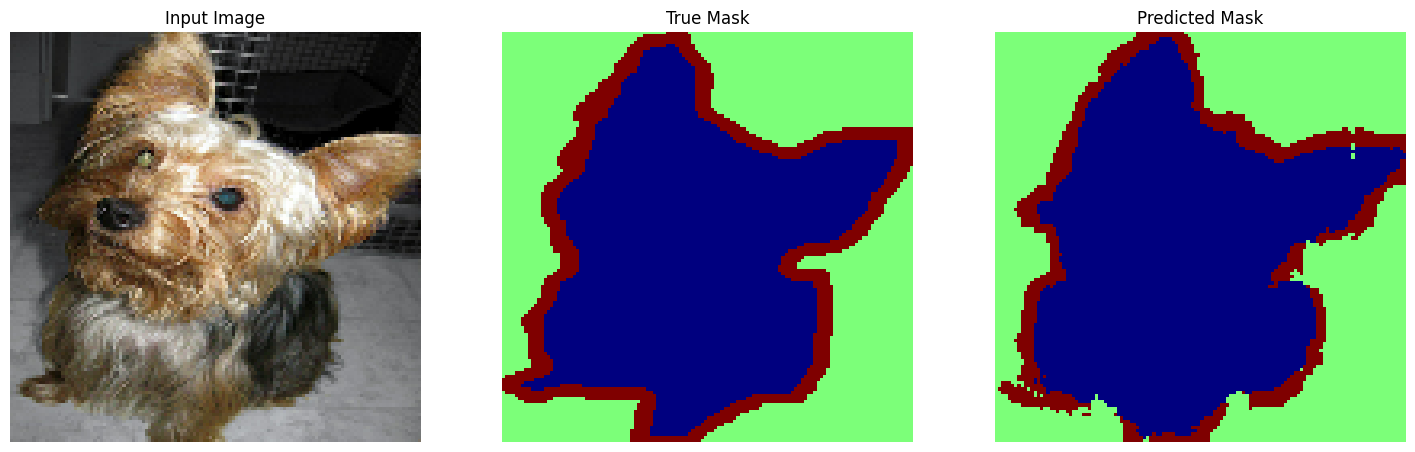


Пример предсказания после эпохи 10
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 275ms/step - accuracy: 0.9193 - iou_coefficient: 0.9145 - loss: 0.2015 - val_accuracy: 0.8993 - val_iou_coefficient: 0.8832 - val_loss: 0.2698


In [ ]:
EPOCHS = 10
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=test_batches,
                    callbacks=[DisplayCallback()])


# Часть 4: Оценка модели

## Построение графиков обучения

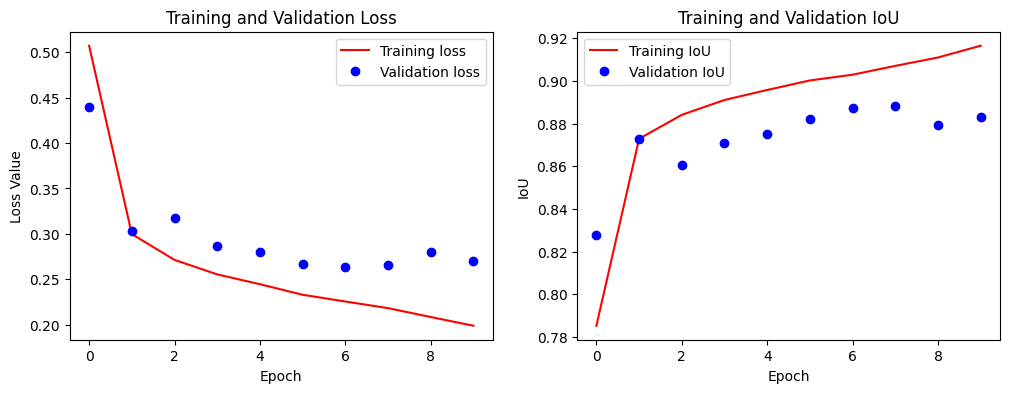

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
iou = history.history['iou_coefficient']
val_iou = history.history['val_iou_coefficient']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(iou, 'r', label='Training IoU')
plt.plot(val_iou, 'bo', label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()


## Визуализация нескольких предсказаний на тестовом наборе

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step


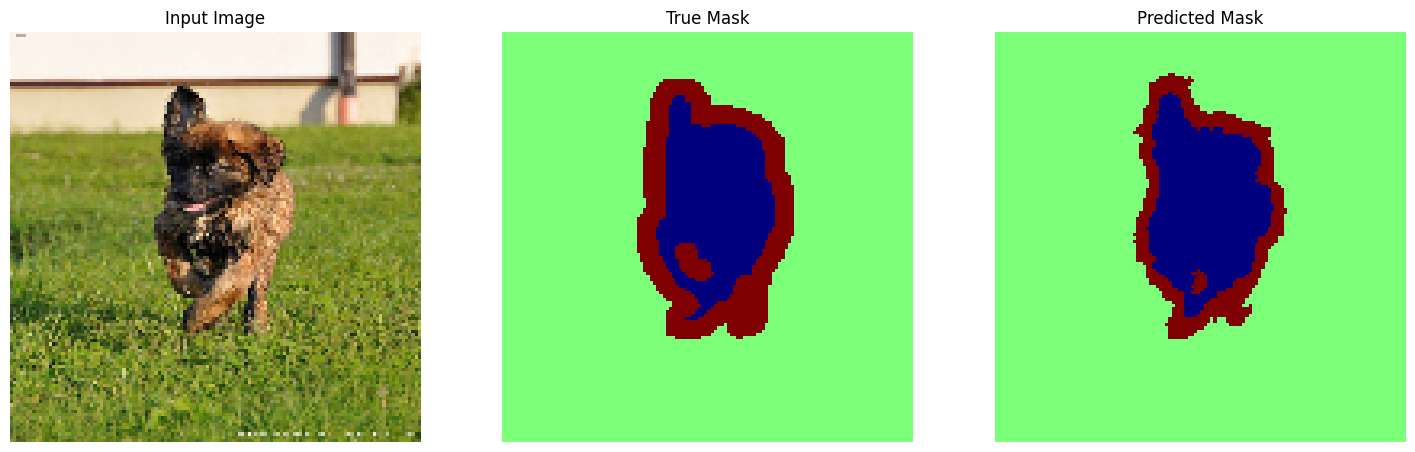

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


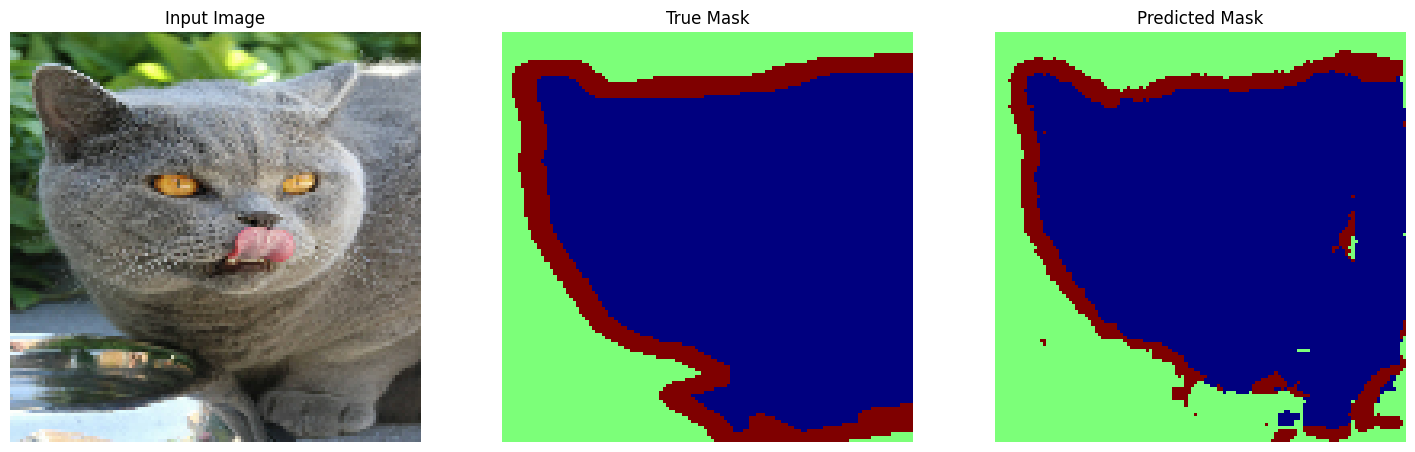

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


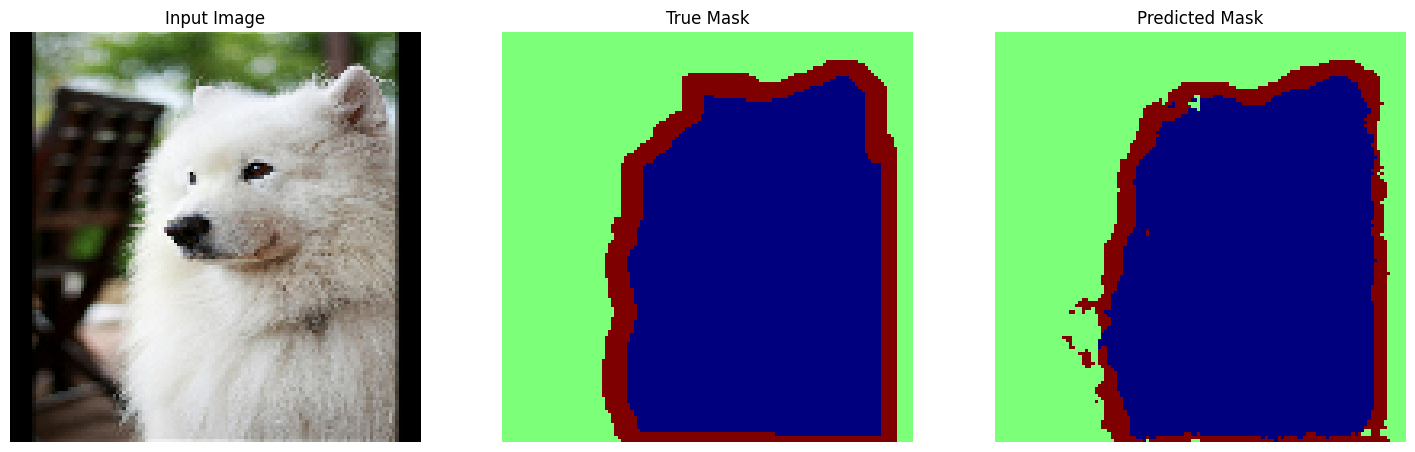

In [ ]:
show_predictions(test_batches, 3)

## Оценка модели на тестовом наборе

In [ ]:
test_loss, test_accuracy, test_iou = model.evaluate(test_batches)
print(f"\nРезультаты на тестовом наборе:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"IoU: {test_iou:.4f}")


58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9006 - iou_coefficient: 0.8845 - loss: 0.2658

Результаты на тестовом наборе:
Loss: 0.2698
Accuracy: 0.8993
IoU: 0.8832


## Функция для расчета Dice Coefficient

In [ ]:
def dice_coefficient(y_true, y_pred):
    # Если y_true имеет каналовое измерение (..., 1), удаляем его
    if y_true.shape[-1] == 1:
        y_true = tf.squeeze(y_true, axis=-1)

    # Преобразуем предсказания в классы (0 или 1 для бинарной сегментации)
    if len(y_pred.shape) == 4:  # (batch_size, h, w, num_classes)
        y_pred_classes = tf.argmax(y_pred, axis=-1)
    else:
        y_pred_classes = tf.cast(y_pred > 0.5, tf.int32)  # Для бинарных предсказаний

    # Преобразуем в int32
    y_true = tf.cast(y_true, tf.int32)
    y_pred_classes = tf.cast(y_pred_classes, tf.int32)

    # Создаем бинарные маски для класса 1
    y_true_binary = tf.equal(y_true, 1)
    y_pred_binary = tf.equal(y_pred_classes, 1)

    # Рассчитываем intersection и суммы
    intersection = tf.reduce_sum(tf.cast(tf.logical_and(y_true_binary, y_pred_binary), tf.float32), axis=[1, 2])
    sum_true = tf.reduce_sum(tf.cast(y_true_binary, tf.float32), axis=[1, 2])
    sum_pred = tf.reduce_sum(tf.cast(y_pred_binary, tf.float32), axis=[1, 2])

    # Рассчитываем Dice для каждого изображения и берем среднее
    dice = (2. * intersection + 1e-7) / (sum_true + sum_pred + 1e-7)
    return tf.reduce_mean(dice).numpy()

## Расчет Dice Coefficient для тестового набора

In [ ]:
y_true_list = []
for _, y_batch in test_batches:
    # y_batch обычно имеет форму (batch_size, height, width, 1)
    y_true_list.append(y_batch.numpy())

y_true_all = np.concatenate(y_true_list, axis=0)

# Получаем предсказания для всего тестового набора
y_pred_all = model.predict(test_batches, verbose=1)

# Рассчитываем Dice Coefficient
dice_score = dice_coefficient(y_true_all, y_pred_all)
print(f"Dice Coefficient: {dice_score:.4f}")


58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step
Dice Coefficient: 0.9338
